## 0) Utilities

In [1]:
## General librairies
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import sys
import time
from copy import deepcopy


## Cosine Distance
from scipy.spatial.distance import cosine


## Keras utilities
import keras
import tensorflow
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
from keras.layers import Input, Conv2D, Lambda,  Dense, Flatten,MaxPooling2D,Dropout, UpSampling2D
# from tensorflow.keras.engine.input_layer import Input
from keras.layers import merge
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
import numpy.random as rng
from sklearn.utils import shuffle

## Sklearn utilities
#### Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#### Scores
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#### Feature transformations
import umap




## Removing some of the useless warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
## Some useful functions to ease the processings
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    x = list(range(len(acc)))
    plt.plot(x,acc)
    plt.plot(x,val_acc)
    
def cat_to_num(y):
    y1 = []
    for i in range(y.shape[0]):
        a = 0
        for j in range(y.shape[1]):
            a += j*y[i,j]
        y1.append(int(a))
    return y1

def generate_integer():
    
    ints = []
    
    while len(ints)<5:
        r = random.randint(0,63)
        if not(r in ints):
            ints.append(r)
    return ints

## 1) Meta Training

#### Neural Net Architecture

In [ ]:
## The ShortLong Stage of the model

def shortlong(x, n_neuron):
    
    x1 = Conv2D(n_neuron, (3,3), activation = 'relu')(x)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = Conv2D(n_neuron, (3,3), activation = 'relu')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = Conv2D(n_neuron, (3,3), activation = 'relu')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    
    x2 = Conv2D(n_neuron, (5,5), activation = 'relu')(x)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = Conv2D(n_neuron, (3,3), activation = 'relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    
    x3 = Conv2D(n_neuron, (7,7), activation = 'relu')(x)
    x3 = keras.layers.BatchNormalization()(x3)
    
#     conc = keras.layers.Concatenate(axis=-1)([x1, x2, x3])
    conc = keras.layers.add(inputs = [x1, x2, x3])
    conc = keras.layers.BatchNormalization()(conc)
    
    final = conc #MaxPooling2D(pool_size=(2, 2))(conc)
    
    return final


## The global architecture called resnet2
def resnet2(output_shape):
    input1 = Input((84,84,3))
    x = shortlong(input1, 64)
    x = shortlong(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = shortlong(x, 80)
    x = shortlong(x, 80)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    
    x = shortlong(x, 230)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation ='relu')(x)
    
    output = Dense(output_shape, activation='softmax')(x)
    
    model = Model(input1, output)
    model.compile(loss="categorical_crossentropy",optimizer=('adam'), metrics = ['accuracy'])
    return model

#### Loading and plotting the meta-learning set

In [ ]:
OT = pickle.load(open('miniImageNet_category_split_train_phase_train.pickle', 'rb'), encoding='latin1')

for i in range(5):
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    ax1.imshow(OT['data'][600*i+1])
    ax2.imshow(OT['data'][600*i+2])    
    ax3.imshow(OT['data'][600*i+3])
    ax4.imshow(OT['data'][600*i+4])
    ax5.imshow(OT['data'][600*i+5])
    
Y_meta = OT['labels']
X_meta = OT['data']

y_meta = np_utils.to_categorical(Y_meta)

#### Setting up the training of the neural net on the meta learning set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

###### First training of the model

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

model = resnet2(64)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

batch_size = 32
epochs = 100

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '2.resnet2 with augmentation', 'results')
save(model, '2.resnet2 with augmentation', 'model')
plot(history)

###### Second training of the model

By the end of this step, the validation accuracy of the model should be around 0.65, you can stop it if it reaches this score

In [ ]:
model = load('2.resnet2 with augmentation', 'model')

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 64
epochs = 5

# aug = ImageDataGenerator(rotation_range=40, zoom_range=0.3,
#                          width_shift_range=0.4, height_shift_range=0.6, shear_range=0.3,
#                          horizontal_flip=True, fill_mode="nearest")

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '2.resnet2 with augmentation 2nd step', 'results')
save(model, '2.resnet2 with augmentation 2nd step', 'model')
plot(history)

###### Third training of the model

Using a different random state in order to use all the data available

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=43)

In [ ]:
model = load('2.resnet2 with augmentation', 'model')

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 64
epochs = 2

# aug = ImageDataGenerator(rotation_range=40, zoom_range=0.3,
#                          width_shift_range=0.4, height_shift_range=0.6, shear_range=0.3,
#                          horizontal_flip=True, fill_mode="nearest")

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '2.resnet2 with augmentation 3rd step', 'results')
save(model, '2.resnet2 with augmentation 3rd step', 'model')

## the current equivalent prétrained model is : '2.resnet2 with augmentation 2'
plot(history)

## 2) Experiments

###### Loading and merging the validation data

In [3]:
OT1 = pickle.load(open('miniImageNet_category_split_test.pickle', 'rb'), encoding='latin1')
OT2 = pickle.load(open('miniImageNet_category_split_val.pickle', 'rb'), encoding='latin1')

from copy import deepcopy
Y_val = deepcopy(OT2['labels'])
X_val = deepcopy(OT2['data'])

## Concatenating val and test datas in order to get more classes for experiment
for i in OT1['labels']:
    Y_val.append(i)
X_val = np.concatenate([X_val, OT1['data']], axis = 0)

## Restructuring the images into an array of size 64*600*84*84*3 to ease the acces to a given class
tab = []
for i in range(36):
    tab.append([])

for i in range(len(Y_val)):
    tab[Y_val[i]-64].append(X_val[i])

X = np.array(tab)

In [71]:
n = 5
k = 5


## A function in order to generate a random array of n distincts values between m and M
def choose_n_classes(n, m, M):
    tab = []
    while len(tab)<n:
        r = random.randint(m,M)
        if not(r in tab):
            tab.append(r)
    tab.sort()
    tab = np.array(tab)
    
    dico = {}
    for i in range(n):
        dico[tab[i]] = i
    
    return tab, dico


## A function to generate data ready for an experiment, tab and dico are here in order to repeat the experiment 
## on the same 5 classes, but with a different number of drawn sample in the class
def build_dataset(X, n,k,value = True, tab = True, dico = True):
    if value == True:
        tab, dico = choose_n_classes(n, 64,99)
    
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    
    print(dico)
    
    for elt in tab:
        ind, dico1 = choose_n_classes(k, 0, 600)
        ind1, dico2 = choose_n_classes(100, 0, 600)
        for i in range(600):
            if i in ind:
                x_train.append(X[elt-64,i])
                y_train.append(dico[elt])
#             elif i in ind1:
#                 x_test.append(X[elt-64,i])
#                 y_test.append(dico[elt])
            else:
                x_test.append(X[elt-64,i])
                y_test.append(dico[elt])
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test), tab, dico

Loading the pre-trained model for features extraction

In [62]:
model_transfert = load('2.resnet2 with augmentation 2', 'model')

inputs = model_transfert.input
outputs = model_transfert.get_layer('batch_normalization_439').output
outputs = Flatten()(outputs)
model = Model(inputs=inputs,   outputs=outputs)

###### Single experiment in n-way, k-shots

Creating the experiment and plotting the class used

{65: 0, 75: 1, 76: 2, 77: 3, 99: 4}


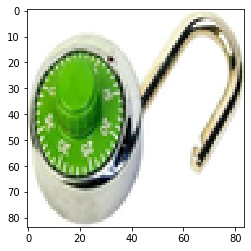

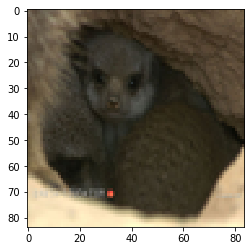

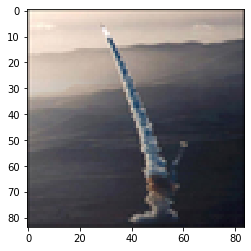

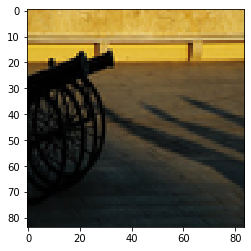

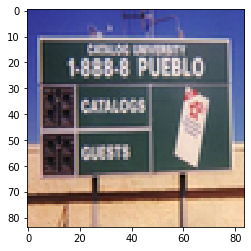

In [63]:
n = 5
k = 5

X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)#, False, tab, dico)

for i in range(5):
    plt.figure(i)
    plt.imshow(X_train[k*i])

Loading the pre-trained Model and transform it into a feature extraction tool

First test with simple transfer learning and logistic regression

In [64]:
y_test1 = np.zeros(y_test.shape[0])-1

Xt = model.predict(X_train)
print(0)
Xv = model.predict(X_test)
print(1)

clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

y_learn = np.concatenate([y_train, y_test1])

0
1
0.7278225806451613


Adding a umap embedding

In [65]:
reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)

y_test_unsupervised = np.zeros(y_test.shape[0])-1
y_learn = np.concatenate([y_train, y_test_unsupervised])

embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

Xt1 = embedding.transform(Xt)
Xv1 = embedding.transform(Xv)

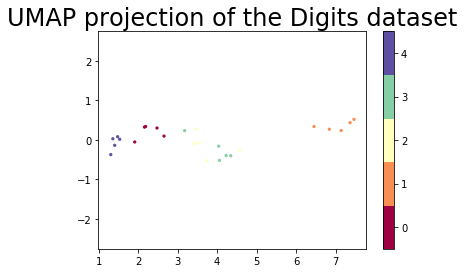

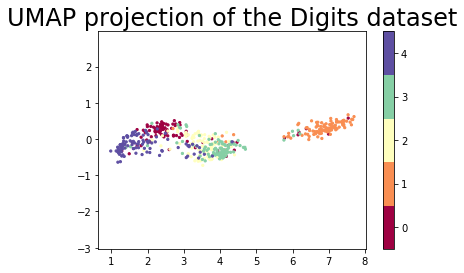

In [66]:
plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

testing with logistic regression

In [67]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(Xt1,y_train)
y_pseudo = clf.predict(Xv1)

print(accuracy_score(y_test, y_pseudo))

0.7459677419354839


Retraining with pseudo labels on original embedding

In [68]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

0.7560483870967742


#### Test with different k in the same n classes

In [60]:
scores1 = []
scores2 = []
scores3 = []

kshots = [1,3, 5,10,50,100,300,500]

for k in kshots:
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k, False, tab, dico)
    
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)
    
    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    y_test1 = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test1])
    
    ## First prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt,y_train)
    
    y_pred = clf.predict(Xv)
    scores1.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    ## Prediction with umap embedding
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt1,y_train)
    
    y_pseudo = clf.predict(Xv1)
    scores2.append(accuracy_score(y_test, y_pseudo))
    
    print(accuracy_score(y_test, y_pseudo))   
    
    ## Final prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
    
    y_pred = clf.predict(Xv)
    scores3.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    
plt.plot(kshots, scores1)
plt.plot(kshots, scores2)
plt.plot(kshots, scores3)

{67: 0, 71: 1, 76: 2, 84: 3, 92: 4}


ValueError: Length of x = 85, length of y = 105, while it must be equal.

#### Generic Experiment for validation and averaging of the final score

In [69]:
scores = []

n = 5
k = 5

for i in range(100):
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)
    
    ## First prediction for comparison
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt,y_train)
    y_pred = clf.predict(Xv)
    print(accuracy_score(y_test, y_pred))
    
    y_test_unsupervised = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test_unsupervised])
    
    ## Prediction with umap embedding
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt1,y_train)
    y_pseudo = clf.predict(Xv1)
    
    print(accuracy_score(y_test, y_pseudo))
    
    ## Final prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
    clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))

    y_pred = clf.predict(Xv)
    accuracy_score(y_test, y_pred)
    
    a = accuracy_score(y_test, y_pred)
    print(a)
    
    scores.append(a)
    
print(np.array(scores).mean())

{76: 0, 82: 1, 91: 2, 93: 3, 94: 4}
0.6909090909090909
0.7111111111111111
0.7131313131313132
{64: 0, 65: 1, 86: 2, 91: 3, 96: 4}
0.5801217038539553
0.6166328600405679
0.6186612576064908
{67: 0, 70: 1, 78: 2, 79: 3, 95: 4}
0.7302231237322515
0.7870182555780934
0.7890466531440162
{69: 0, 76: 1, 80: 2, 91: 3, 99: 4}
0.7648261758691206
0.7995910020449898
0.803680981595092
{64: 0, 73: 1, 76: 2, 92: 3, 96: 4}
0.744466800804829
0.7927565392354124
0.7927565392354124
{65: 0, 67: 1, 87: 2, 89: 3, 95: 4}
0.6875
0.7237903225806451
0.7358870967741935
{73: 0, 88: 1, 91: 2, 94: 3, 97: 4}
0.6693386773547094
0.6833667334669339
0.6893787575150301
{68: 0, 69: 1, 73: 2, 89: 3, 93: 4}
0.6348884381338742
0.5943204868154158
0.5983772819472617
{81: 0, 85: 1, 87: 2, 92: 3, 98: 4}
0.7975708502024291
0.8157894736842105
0.819838056680162
{64: 0, 72: 1, 78: 2, 85: 3, 98: 4}
0.8084677419354839
0.8366935483870968
0.8407258064516129
{65: 0, 80: 1, 84: 2, 89: 3, 91: 4}
0.6385542168674698
0.6887550200803213
0.692771084

0.7449392712550608
0.805668016194332
0.8076923076923077
{72: 0, 78: 1, 88: 2, 94: 3, 98: 4}
0.8209255533199196
0.8450704225352113
0.8490945674044266
{67: 0, 74: 1, 92: 2, 94: 3, 97: 4}
0.7327935222672065
0.7327935222672065
0.7368421052631579
{82: 0, 84: 1, 90: 2, 98: 3, 99: 4}
0.7670682730923695
0.8012048192771084
0.8052208835341366
{65: 0, 68: 1, 80: 2, 89: 3, 95: 4}
0.5777777777777777
0.5878787878787879
0.604040404040404
{67: 0, 72: 1, 80: 2, 83: 3, 98: 4}
0.7651821862348178
0.8097165991902834
0.8117408906882592
{66: 0, 82: 1, 84: 2, 86: 3, 99: 4}
0.7198364008179959
0.7361963190184049
0.7423312883435583
{66: 0, 71: 1, 72: 2, 81: 3, 87: 4}
0.8461538461538461
0.8360323886639676
0.8340080971659919
{75: 0, 81: 1, 83: 2, 88: 3, 99: 4}
0.7105263157894737
0.7753036437246964
0.7813765182186235
{77: 0, 84: 1, 87: 2, 88: 3, 99: 4}
0.8366935483870968
0.8850806451612904
0.8830645161290323
{65: 0, 76: 1, 77: 2, 80: 3, 84: 4}
0.6910569105691057
0.7215447154471545
0.7215447154471545
0.7825107880190

(array([ 1.,  0.,  0.,  2.,  1.,  0.,  1.,  3.,  6.,  7.,  8.,  7., 10.,
        11., 14.,  8., 10.,  7.,  3.,  1.]),
 array([0.52610442, 0.54605426, 0.5660041 , 0.58595394, 0.60590378,
        0.62585362, 0.64580346, 0.6657533 , 0.68570314, 0.70565298,
        0.72560282, 0.74555266, 0.7655025 , 0.78545234, 0.80540218,
        0.82535202, 0.84530186, 0.8652517 , 0.88520153, 0.90515137,
        0.92510121]),
 <a list of 20 Patch objects>)

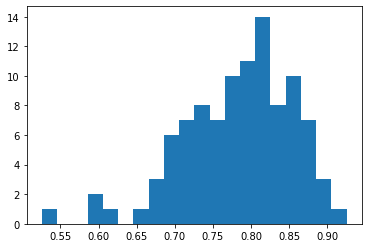

In [70]:
plt.hist(scores, bins = 20)